In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
from skimage import measure
from tqdm import tqdm, trange

from core.dataset import ScanNet
from core.integrate import PanopticFusionScalableTSDFVolume
from core.integrate.utils.misc import instance_id_to_one_hot_mask

draw = o3d.visualization.EV.draw

In [42]:
color_set = np.random.random(size=(512, 3))

In [3]:
save_dir = '/storage/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/connectivity_graph_SVP/'

In [4]:
border_counts = np.load(save_dir + 'border_counts.npy')
positive_connectivity = np.load(save_dir + 'positive_connectivity.npy')
negative_connectivity = np.load(save_dir + 'negative_connectivity.npy')

In [5]:
idx = np.arange(border_counts.shape[0])

In [6]:
edge_mask = idx.reshape(-1, 1) < idx.reshape(1, -1)

/tmp/ipykernel_1330010/3301679409.py:1: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.log(positive_connectivity)[edge_mask * (positive_connectivity > 0)], bins=100)[2]


<BarContainer object of 100 artists>

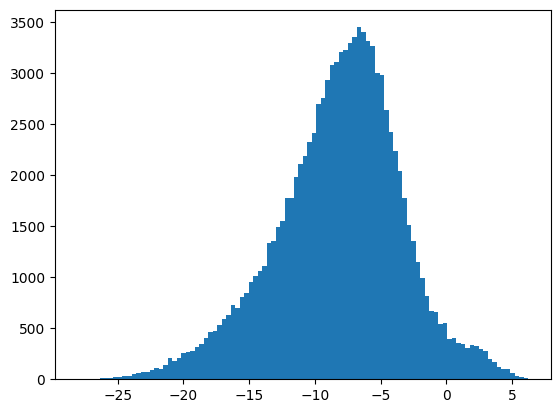

In [7]:
plt.hist(np.log(positive_connectivity)[edge_mask * (positive_connectivity > 0)], bins=100)[2]

/tmp/ipykernel_1330010/3984105442.py:1: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.log(negative_connectivity)[edge_mask * (negative_connectivity > 0)], bins=100)[2]


<BarContainer object of 100 artists>

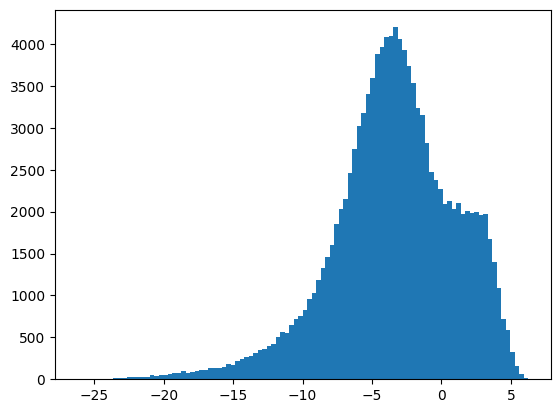

In [8]:
plt.hist(np.log(negative_connectivity)[edge_mask * (negative_connectivity > 0)], bins=100)[2]

<BarContainer object of 100 artists>

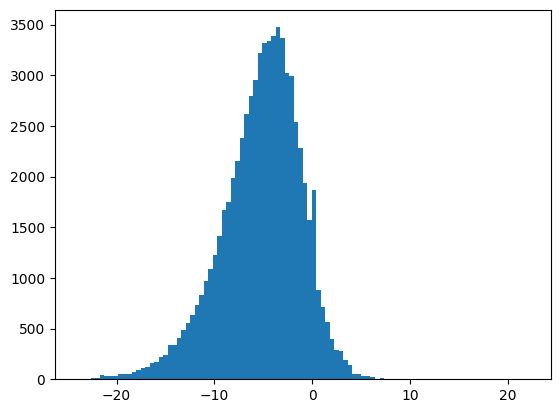

In [9]:
log_ratio = np.log(1e-8 + positive_connectivity) - np.log(1e-8 + negative_connectivity)
plt.hist(log_ratio[edge_mask * (border_counts > 0)], bins=100)[2]

In [34]:
from scipy.sparse import csgraph, csr_matrix

positive_threshold = 3.0
log_ratio_threshold = 3.0

adjacency_matrix = (positive_connectivity > positive_threshold) * (log_ratio > log_ratio_threshold) * (border_counts > 0)

sparse_matrix = csr_matrix(adjacency_matrix)
n_components, labels = csgraph.connected_components(sparse_matrix)

In [35]:
n_components, labels

(330,
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,   7,  18,  19,   7,  20,  21,  22,  23,
         24,  25,  26,  27,  28,  29,  30,  31,  23,  32,  33,  34,  35,
         36,   2,  37,   0,  38,   7,  39,  40,   3,  23,  41,  42,  43,
          7,   7,   7,  44,  45,  46,   0,  23,  47,  48,  49,   7,  50,
         51,  52,  53,  54,  55,  25,  23,  56,  23,  57,  58,  59,  60,
         61,  62,  63,  64,  65,   3,   7,  66,  67,  68,  21,  21,  69,
         70,  21,  71,  72,  38,  73,  74,  75,  72,   7,   7,  23,  76,
         77,   7,  78,  31,  31,   0,  79,  80,  81,  82,  59,  83,  61,
         84,  85,  86,  31,   7,  87,   0,  88,  89,  79,  90,  91,  92,
         93,  94,  95,   7,  96,  97,  98,  99, 100, 101, 102,   3,  23,
        103,  59, 104, 105,   3, 106,  94, 107, 108, 109,   7, 110, 111,
        112, 113, 114, 115, 116, 117,  93, 118, 119, 120, 121, 122, 123,
         85, 124, 125, 126, 127, 128, 129, 13

In [36]:
tsdf_device = "cuda:1"
tsdf_volume = PanopticFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device=tsdf_device,
)

save_dir = "/storage/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/"
# save_dir = "/storage/quanta/Experiments/feature-instance-fusion/scannet_scene0645_01/"
# save_dir = "/storage/quanta/Experiments/feature-instance-fusion/scannet_scene0643_00/"
# save_dir = "/storage/quanta/Experiments/feature-instance-fusion/scannet_scene0488_01/"
tsdf_volume.load(save_dir + "tsdf/tsdf_volume.pt")
voxel_patch_labels = torch.load(save_dir + "kmeans_random_sam/kmeans_labels.pt").to(tsdf_device)
voxel_labels = torch.from_numpy(labels).to(device=tsdf_device, dtype=torch.int64)[voxel_patch_labels]


In [39]:
voxel_labels = voxel_patch_labels

In [40]:
tsdf_volume.reset_instance()
tsdf_volume._instance_label_num = 512
tsdf_volume._instance = voxel_labels

In [44]:
verts, faces = tsdf_volume.extract_mesh()
mesh = o3d.geometry.TriangleMesh(
    vertices=o3d.utility.Vector3dVector(verts),
    triangles=o3d.utility.Vector3iVector(faces),
)
labels = tsdf_volume.extract_label_on_grid(verts=verts, device=tsdf_device)[0]
color = color_set[labels]

mesh.compute_vertex_normals()
mesh.vertex_colors = o3d.utility.Vector3dVector(color)

draw([mesh])

: 